In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 서울시 구별 범죄 현황 분석

+ 부제 
    - CCTV와 범죄, 검거율에 관계가 있는가?
    - 강남 3구는 과연 범죄 발생율이 낮고 검거율이 높은가?

### 1. 데이터 준비

+ https://www.data.go.kr
+ 구글에서 "서울시 관서별 5대범죄 발생검거 현황" 검색
+ crime_in_seoul.csv

In [2]:
crime_anal_police = pd.read_csv("data/seoul/crime_in_seoul.csv", encoding="euc-kr", thousands=",")
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170
1,종로서,3,3,6,5,115,98,1070,413,1278,1070
2,남대문서,1,0,6,4,65,46,1153,382,869,794
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711
4,혜화서,3,2,5,4,96,63,1114,424,1015,861


In [3]:
crime_anal_police.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   관서명     31 non-null     object
 1   살인 발생   31 non-null     int64 
 2   살인 검거   31 non-null     int64 
 3   강도 발생   31 non-null     int64 
 4   강도 검거   31 non-null     int64 
 5   강간 발생   31 non-null     int64 
 6   강간 검거   31 non-null     int64 
 7   절도 발생   31 non-null     int64 
 8   절도 검거   31 non-null     int64 
 9   폭력 발생   31 non-null     int64 
 10  폭력 검거   31 non-null     int64 
dtypes: int64(10), object(1)
memory usage: 2.8+ KB


### 2. EDA & Preprocessing

#### 2-1. 관서명을 구 이름으로 변경

+ https://ko.wikipedia.org/wiki/서울특별시지방경찰청


+ GoogleMap API를 이용하여 주소 획득
    - https://developers.google.com
    - https://cloud.google.com/maps-platform/?hl=ko
    - pip install googlemaps


+ KaKao API를 이용하여 주소 획득
    - https://developers.kakao.com
        - 시작하기 클릭
        - 어플리케이션 추가
        - rest api 키 복사
        - 플랫폼 설정하기 : Web 플랫폼 선택, http://localhost:8888 등록
        - Redirect URI 등록하기
            - 활성화
            - Redirect URI 등록 : http://localhost:8888
            
    - https://kauth.kakao.com/oauth/authorize?client_id=api키복사하기&redirect_uri=http://localhost:8888&response_type=code
    

In [3]:
import requests

header = {"Authorization":"KakaoAK 2fc60a429733da6fb3c988d4924ec63b"}
url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format("서울중부경찰서")

#requests.get(url, headers=header).json()["documents"][0]["address_name"]

type(requests.get(url, headers=header).json())
requests.get(url, headers=header).json()

{'documents': [{'address_name': '서울 중구 저동2가 62-1',
   'category_group_code': 'PO3',
   'category_group_name': '공공기관',
   'category_name': '사회,공공기관 > 행정기관 > 경찰서',
   'distance': '',
   'id': '11151738',
   'phone': '',
   'place_name': '서울중부경찰서',
   'place_url': 'http://place.map.kakao.com/11151738',
   'road_address_name': '서울 중구 수표로 27',
   'x': '126.98958691395208',
   'y': '37.56361812722828'},
  {'address_name': '서울 중구 저동2가 62-1',
   'category_group_code': '',
   'category_group_name': '',
   'category_name': '사회,공공기관 > 행정기관부속시설',
   'distance': '',
   'id': '10795753',
   'phone': '',
   'place_name': '중부경찰서 민원봉사실',
   'place_url': 'http://place.map.kakao.com/10795753',
   'road_address_name': '서울 중구 수표로 27',
   'x': '126.990026067084',
   'y': '37.5636740269204'},
  {'address_name': '서울 중구 저동2가 62-1',
   'category_group_code': 'CT1',
   'category_group_name': '문화시설',
   'category_name': '문화,예술 > 문화시설 > 박물관',
   'distance': '',
   'id': '27184424',
   'phone': '',
   'place_name':

In [20]:
##### 경찰서 이름을 완전한 이름으로 변경

station_name = []
for name in crime_anal_police["관서명"]:
    station_name.append("서울" + name[:-1] + "경찰서")
    
print(station_name)

['서울중부경찰서', '서울종로경찰서', '서울남대문경찰서', '서울서대문경찰서', '서울혜화경찰서', '서울용산경찰서', '서울성북경찰서', '서울동대문경찰서', '서울마포경찰서', '서울영등포경찰서', '서울성동경찰서', '서울동작경찰서', '서울광진경찰서', '서울서부경찰서', '서울강북경찰서', '서울금천경찰서', '서울중랑경찰서', '서울강남경찰서', '서울관악경찰서', '서울강서경찰서', '서울강동경찰서', '서울종암경찰서', '서울구로경찰서', '서울서초경찰서', '서울양천경찰서', '서울송파경찰서', '서울노원경찰서', '서울방배경찰서', '서울은평경찰서', '서울도봉경찰서', '서울수서경찰서']


In [21]:
##### 경찰서 주소와 위도, 경도 값을 받아오기

station_address = []
station_lat = []
station_lng = []

for name in station_name:
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(name)
    place = requests.get(url, headers=header).json()["documents"]
    
    station_address.append(place[0].get("address_name"))
    station_lat.append(place[0].get('y'))
    station_lng.append(place[0]['x'])
    
    print(name + "-------------->" + place[0].get("address_name"))

서울중부경찰서-------------->서울 중구 저동2가 62-1
서울종로경찰서-------------->서울 종로구 경운동 90-18
서울남대문경찰서-------------->서울 중구 남대문로5가 567
서울서대문경찰서-------------->서울 서대문구 미근동 165
서울혜화경찰서-------------->서울 종로구 인의동 48-57
서울용산경찰서-------------->서울 용산구 원효로1가 12-12
서울성북경찰서-------------->서울 성북구 삼선동5가 301
서울동대문경찰서-------------->서울 동대문구 청량리동 229
서울마포경찰서-------------->서울 마포구 아현동 618-1
서울영등포경찰서-------------->서울 영등포구 당산동3가 2-11
서울성동경찰서-------------->서울 성동구 행당동 192-8
서울동작경찰서-------------->서울 동작구 노량진동 72-35
서울광진경찰서-------------->서울 광진구 구의동 254-32
서울서부경찰서-------------->서울 은평구 녹번동 177-15
서울강북경찰서-------------->서울 강북구 번동 415-15
서울금천경찰서-------------->서울 금천구 시흥동 1030
서울중랑경찰서-------------->서울 중랑구 신내동 810
서울강남경찰서-------------->서울 강남구 대치동 998
서울관악경찰서-------------->서울 관악구 봉천동 1695-5
서울강서경찰서-------------->서울 강서구 화곡동 980-27
서울강동경찰서-------------->서울 강동구 성내동 541-1
서울종암경찰서-------------->서울 성북구 종암동 3-1260
서울구로경찰서-------------->서울 구로구 구로동 436
서울서초경찰서-------------->서울 서초구 서초동 1726-1
서울양천경찰서-------------->서울 양천구 신정동 321
서울송파경찰서--------------

In [164]:
# 구글의 geocoding api의 경우
"""
[{'address_components': [{'long_name': '４０３',
    'short_name': '４０３',
    'types': ['premise']},
   {'long_name': '노해로',
    'short_name': '노해로',
    'types': ['political', 'sublocality', 'sublocality_level_4']},
   {'long_name': '창4동',
    'short_name': '창4동',
    'types': ['political', 'sublocality', 'sublocality_level_2']},
   {'long_name': '도봉구',
    'short_name': '도봉구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '132-040',
    'short_name': '132-040',
    'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 도봉구 창4동 노해로 403',
  'geometry': {'location': {'lat': 37.6533589, 'lng': 127.052682},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.6547078802915,
     'lng': 127.0540309802915},
    'southwest': {'lat': 37.6520099197085, 'lng': 127.0513330197085}}},
  'place_id': 'ChIJTUiMyEW5fDURH_6VenyTTpw',
  'plus_code': {'compound_code': 'M333+83 대한민국 서울특별시',
   'global_code': '8Q99M333+83'},
  'types': ['establishment', 'point_of_interest', 'police']}]
"""

"\n[{'address_components': [{'long_name': '４０３',\n    'short_name': '４０３',\n    'types': ['premise']},\n   {'long_name': '노해로',\n    'short_name': '노해로',\n    'types': ['political', 'sublocality', 'sublocality_level_4']},\n   {'long_name': '창4동',\n    'short_name': '창4동',\n    'types': ['political', 'sublocality', 'sublocality_level_2']},\n   {'long_name': '도봉구',\n    'short_name': '도봉구',\n    'types': ['political', 'sublocality', 'sublocality_level_1']},\n   {'long_name': '서울특별시',\n    'short_name': '서울특별시',\n    'types': ['administrative_area_level_1', 'political']},\n   {'long_name': '대한민국',\n    'short_name': 'KR',\n    'types': ['country', 'political']},\n   {'long_name': '132-040',\n    'short_name': '132-040',\n    'types': ['postal_code']}],\n  'formatted_address': '대한민국 서울특별시 도봉구 창4동 노해로 403',\n  'geometry': {'location': {'lat': 37.6533589, 'lng': 127.052682},\n   'location_type': 'ROOFTOP',\n   'viewport': {'northeast': {'lat': 37.6547078802915,\n     'lng': 127.0540309802915

In [13]:
'''
station_address = ['대한민국 서울특별시 중구 을지로동 수표로 27', '대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46', '대한민국 서울특별시 중구 회현동 한강대로 410', '대한민국 서울특별시 서대문구 충현동 통일로 113', '대한민국 서울특별시 종로구 인의동 창경궁로 112-16', '대한민국 서울특별시 용산구 원효로1가 백범로 329', '대한민국 서울특별시 성북구 삼선동5가 301', '대한민국 서울특별시 동대문구 청량리동 약령시로21길 29', '대한민국 서울특별시 마포구 아현동 마포대로 183', '대한민국 서울특별시 영등포구 영등포동1가 618-7', '대한민국 서울특별시 성동구 행당동 왕십리광장로 9', '대한민국 서울특별시 동작구 노량진1동 노량진로 148', '대한민국 서울특별시 광진구 구의동 자양로 167', '대한민국 서울특별시 은평구 녹번동 진흥로 58', '대한민국 서울특별시 강북구 번1동 오패산로 406', '대한민국 서울특별시 금천구 시흥1동 시흥대로73길 50', '대한민국 서울특별시 중랑구 신내동 신내역로3길 40-10', '대한민국 서울특별시 강남구 대치동 998', '대한민국 서울특별시 관악구 봉천동', '대한민국 서울특별시 양천구 신월동 화곡로 73', '대한민국 서울특별시 강동구 성내1동 성내로 57', '대한민국 서울특별시 성북구 종암동 종암로 135', '대한민국 서울특별시 구로구 구로동 가마산로 235', '대한민국 서울특별시 서초구 서초3동 반포대로 179', '대한민국 서울특별시 양천구 신정6동 목동동로 99', '대한민국 서울특별시 송파구 가락동 중대로 221', '대한민국 서울특별시 노원구 하계동 노원로 283', '대한민국 서울특별시 서초구 방배본동 동작대로 204', '대한민국 서울특별시 은평구 불광동 연서로 365', '대한민국 서울특별시 도봉구 창4동 노해로 403', '대한민국 서울특별시 강남구 개포동 개포로 617']
station_lat = [37.5636465, 37.5755578, 37.5547584, 37.5647439, 37.5718529, 37.5387099, 37.5897482, 37.58506149999999, 37.550814, 37.5153176, 37.5617303, 37.5130866, 37.542873, 37.6020914, 37.63730390000001, 37.4568722, 37.6186095, 37.5094352, 37.4743789, 37.5397827, 37.528511, 37.6020592, 37.494931, 37.4956054, 37.5165667, 37.5016941, 37.6425238, 37.4945959, 37.6283597, 37.6533589, 37.49349]
station_lng = [126.9895796, 126.9848674, 126.9734981, 126.9667705, 126.9989143, 126.9659183, 127.0161353, 127.0457679, 126.954028, 126.905728, 127.0364217, 126.9428498, 127.083821, 126.9213528, 127.0273399, 126.8970429, 127.1045734, 127.0669578, 126.9509748, 126.8299968, 127.1268224, 127.0321577, 126.886731, 127.0052504, 126.8656763, 127.1272481, 127.0717076, 126.9831279, 126.9287226, 127.052682, 127.0772119]
'''

In [17]:
station_address
station_lat
station_lng

['126.98958691395208',
 '126.98489861889408',
 '126.97349729923079',
 '126.966790740735',
 '126.998935936567',
 '126.96777437089538',
 '127.01625465308534',
 '127.045762797538',
 '126.95394117396',
 '126.90094457988',
 '127.036472076258',
 '126.942857105642',
 '127.08396170505674',
 '126.92131688777927',
 '127.02733870040592',
 '126.89674921449215',
 '127.10454224897',
 '127.067070541137',
 '126.951062346192',
 '126.849886071842',
 '127.12688982770433',
 '127.032233767891',
 '126.886660285169',
 '127.00528097622329',
 '126.865542970902',
 '127.12716129352492',
 '127.071404832413',
 '126.98300906928465',
 '126.928631038584',
 '127.05270598499145',
 '127.077143044327']

In [171]:
##### 받은 주소에서 구 이름만 추출

df = pd.DataFrame([station_address, station_lat, station_lng]).T
df.columns = ['구별', '위도', '경도']
df['구별'] = df['구별'].str.split(" ", expand=True)[1]
df


,구별,위도,경도
0,중구,37.56361812722828,126.98958691395208
1,종로구,37.57553779077874,126.98489861889408
2,중구,37.55478043476484,126.97349729923079
3,서대문구,37.5649023404956,126.966790740735
4,종로구,37.5718915247338,126.998935936567
5,용산구,37.54117933635974,126.96777437089538
6,성북구,37.58989767143614,127.01625465308534
7,동대문구,37.5850804205685,127.045762797538
8,마포구,37.5510118582052,126.95394117396
9,영등포구,37.52585220719,126.90094457988


In [17]:
adress = []
for i in range(len(station_address)):
    adress.append(station_address[i].split()[2])
    
adress

['중구',
 '종로구',
 '중구',
 '서대문구',
 '종로구',
 '용산구',
 '성북구',
 '동대문구',
 '마포구',
 '영등포구',
 '성동구',
 '동작구',
 '광진구',
 '은평구',
 '강북구',
 '금천구',
 '중랑구',
 '강남구',
 '관악구',
 '양천구',
 '강동구',
 '성북구',
 '구로구',
 '서초구',
 '양천구',
 '송파구',
 '노원구',
 '서초구',
 '은평구',
 '도봉구',
 '강남구']

In [19]:
df= pd.DataFrame([station_address, station_lat, station_lng]).T
df.columns=["주소", "위도","경도"]

df["구별"]= df["주소"].str.extract("\s(\w+구)")
df["구별"]

0       중구
1      종로구
2       중구
3     서대문구
4      종로구
5      용산구
6      성북구
7     동대문구
8      마포구
9     영등포구
10     성동구
11     동작구
12     광진구
13     은평구
14     강북구
15     금천구
16     중랑구
17     강남구
18     관악구
19     양천구
20     강동구
21     성북구
22     구로구
23     서초구
24     양천구
25     송파구
26     노원구
27     서초구
28     은평구
29     도봉구
30     강남구
Name: 구별, dtype: object

In [20]:
import re
lst = list()
for i in range(len(station_address)):
    a = re.search("[가-힣]+구", station_address[i]).group()
    lst.append(a)
print(lst)

['중구', '종로구', '중구', '서대문구', '종로구', '용산구', '성북구', '동대문구', '마포구', '영등포구', '성동구', '동작구', '광진구', '은평구', '강북구', '금천구', '중랑구', '강남구', '관악구', '양천구', '강동구', '성북구', '구로구', '서초구', '양천구', '송파구', '노원구', '서초구', '은평구', '도봉구', '강남구']


In [172]:
gu_names = []

for name in station_address:
    tmp = name.split()
    
    tmp_gu = [gu for gu in tmp if gu[-1] == "구"][0]
    gu_names.append(tmp_gu)
    
print(gu_names)

['중구', '종로구', '중구', '서대문구', '종로구', '용산구', '성북구', '동대문구', '마포구', '영등포구', '성동구', '동작구', '광진구', '은평구', '강북구', '금천구', '중랑구', '강남구', '관악구', '강서구', '강동구', '성북구', '구로구', '서초구', '양천구', '송파구', '노원구', '서초구', '은평구', '도봉구', '강남구']


In [173]:
##### 테이블에 "구별" 컬럼 추가

crime_anal_police["구별"] = gu_names
crime_anal_police

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563646,126.989580,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575558,126.984867,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564744,126.966770,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571853,126.998914,1.198382
5,용산서,5,5,14,14,194,173,1557,587,2050,1704,용산구,37.538710,126.965918,2.690685
6,성북서,2,2,2,1,86,71,953,409,1194,1015,성북구,37.589748,127.016135,1.155649
7,동대문서,5,5,13,13,173,146,1981,814,2548,2227,동대문구,37.585061,127.045768,2.897302
8,마포서,8,8,14,10,294,247,2555,813,2983,2519,마포구,37.550814,126.954028,3.538657
9,영등포서,14,12,22,20,295,183,2964,978,3572,2961,영등포구,37.515318,126.905728,4.275979


In [28]:
##### 강서경찰서는 강서구로 변경

#crime_anal_police["구별"][19] = "강서구"
#crime_anal_police.loc[19]["구별"] = "강서구"

#crime_anal_police.loc[crime_anal_police["관서명"] == "강서서", ["구별"]] = "강서구"
#crime_anal_police.loc[crime_anal_police["관서명"] == "강서서"]
#crime_anal_police

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구
5,용산서,5,5,14,14,194,173,1557,587,2050,1704,용산구
6,성북서,2,2,2,1,86,71,953,409,1194,1015,성북구
7,동대문서,5,5,13,13,173,146,1981,814,2548,2227,동대문구
8,마포서,8,8,14,10,294,247,2555,813,2983,2519,마포구
9,영등포서,14,12,22,20,295,183,2964,978,3572,2961,영등포구


#### 2-2. checkpoint

In [174]:
crime_anal_police.to_csv("data/seoul/crime_in_seoul_include_gu_name.csv", encoding="utf-8")

In [175]:
crime_anal_raw = pd.read_csv("data/seoul/crime_in_seoul_include_gu_name.csv", index_col=0)
crime_anal_raw

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563647,126.989580,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575558,126.984867,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564744,126.966771,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571853,126.998914,1.198382
5,용산서,5,5,14,14,194,173,1557,587,2050,1704,용산구,37.538710,126.965918,2.690685
6,성북서,2,2,2,1,86,71,953,409,1194,1015,성북구,37.589748,127.016135,1.155649
7,동대문서,5,5,13,13,173,146,1981,814,2548,2227,동대문구,37.585061,127.045768,2.897302
8,마포서,8,8,14,10,294,247,2555,813,2983,2519,마포구,37.550814,126.954028,3.538657
9,영등포서,14,12,22,20,295,183,2964,978,3572,2961,영등포구,37.515318,126.905728,4.275979


#### 2-3. 관서명을 없애고 구별을 인덱스로 설정

In [176]:
##### 관서명 기준이기 때문에 "구별"값이 중복된다. 이것을 해결하기 위한 방법

#crime_anal_raw.drop("관서명", axis = 1, inplace = True)
#crime_anal_raw.set_index(['구별'],inplace = True)

#del crime_anal_raw["관서명"]
#crime_anal_raw = crime_anal_raw.set_index("구별")
#crime_anal_raw

#del crime["관서명"]
#crime = crime.groupby("구별").sum()
#crime

crime_anal = pd.pivot_table(crime_anal_raw, index='구별', aggfunc = "sum")

In [177]:
crime_anal.head()

,lat,lng,강간 검거,강간 발생,강도 검거,강도 발생,검거,살인 검거,살인 발생,절도 검거,절도 발생,폭력 검거,폭력 발생
구별,,,,,,,,,,,,,
강남구,75.002925,254.144170,349,449,18,21,5.481954,10,13,1650,3850,3705,4284
강동구,37.528511,127.126822,123,156,8,6,2.432725,3,4,789,2366,2248,2712
강북구,37.637304,127.027340,126,153,13,14,2.953710,8,7,618,1434,2348,2649
강서구,37.539783,126.829997,191,262,13,13,3.844567,8,7,1260,2096,2718,3207
관악구,37.474379,126.950975,221,320,14,12,3.639743,8,9,827,2706,2642,3298


#### 2-4. 각 범죄별 검거율을 계산하여 파생변수 추가하고, 각 검거 컬럼은 삭제

In [178]:
crime_anal["강간검거율"] = crime_anal["강간 검거"] / crime_anal["강간 발생"] * 100
crime_anal["강도검거율"] = crime_anal["강도 검거"] / crime_anal["강도 발생"] * 100
crime_anal["살인검거율"] = crime_anal["살인 검거"] / crime_anal["살인 발생"] * 100
crime_anal["절도검거율"] = crime_anal["절도 검거"] / crime_anal["절도 발생"] * 100
crime_anal["폭력검거율"] = crime_anal["폭력 검거"] / crime_anal["폭력 발생"] * 100

del crime_anal["강간 검거"]
del crime_anal["강도 검거"]
del crime_anal["살인 검거"]
del crime_anal["절도 검거"]
del crime_anal["폭력 검거"]

In [179]:
crime_anal.head()

,lat,lng,강간 발생,강도 발생,검거,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,,,,
강남구,75.002925,254.144170,449,21,5.481954,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,37.528511,127.126822,156,6,2.432725,4,2366,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,37.637304,127.027340,153,14,2.953710,7,1434,2649,82.352941,92.857143,114.285714,43.096234,88.637222
강서구,37.539783,126.829997,262,13,3.844567,7,2096,3207,72.900763,100.000000,114.285714,60.114504,84.752105
관악구,37.474379,126.950975,320,12,3.639743,9,2706,3298,69.062500,116.666667,88.888889,30.561715,80.109157


In [180]:
##### "발생" 이라는 단어는 삭제(컬럼 변경)

crime_anal.rename(columns = {"강간 발생":"강간", "강도 발생":"강도", "살인 발생":"살인",
                            "절도 발생":"절도", "폭력 발생":"폭력"}, inplace=True)
crime_anal.head()

,lat,lng,강간,강도,검거,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,,,,
강남구,75.002925,254.144170,449,21,5.481954,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,37.528511,127.126822,156,6,2.432725,4,2366,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,37.637304,127.027340,153,14,2.953710,7,1434,2649,82.352941,92.857143,114.285714,43.096234,88.637222
강서구,37.539783,126.829997,262,13,3.844567,7,2096,3207,72.900763,100.000000,114.285714,60.114504,84.752105
관악구,37.474379,126.950975,320,12,3.639743,9,2706,3298,69.062500,116.666667,88.888889,30.561715,80.109157


In [181]:
##### 검거율에서 100이 넘는 값들은 모두 100으로 맞춰준다.

for col in ["강간검거율","강도검거율","살인검거율","절도검거율","폭력검거율"]:
    crime_anal.loc[crime_anal[col] > 100, col] = 100
    
crime_anal.head()

,lat,lng,강간,강도,검거,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,,,,
강남구,75.002925,254.144170,449,21,5.481954,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,37.528511,127.126822,156,6,2.432725,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,37.637304,127.027340,153,14,2.953710,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,37.539783,126.829997,262,13,3.844567,7,2096,3207,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,37.474379,126.950975,320,12,3.639743,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157


#### 2-5. 정규화 / 표준화 : 수치 데이터에 대한 rescaling

+ 정규화(Normalization)
    - 데이터의 상대적인 크기에 대해 영향을 줄이기 위해 데이터 범위를 0 ~ 1로 변환
    - (측정값 - 최소값) / (최대값 - 최소값)
    
    

+ 표준화(Standardization)
    - 데이터가 평균으로부터 얼마나 떨어져 있는지 나타내는 값으로, 특정 범위를 벗어난 데이터는 이상치로 간주
    - (측정값 - 평균) / 표준편차

In [182]:
##### Normalization

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

cols = ["강간", "강도", "살인", "절도", "폭력"]
x = crime_anal[cols].values

x_scaled = min_max_scaler.fit_transform(x)

crime_anal_norm = pd.DataFrame(x_scaled, columns=cols, index=crime_anal.index)
crime_anal_norm.head()

cols2 = ["강간검거율", "강도검거율", "살인검거율", "절도검거율", "폭력검거율"]

crime_anal_norm[cols2] = crime_anal[cols2]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157


#### 2-6. 인구수 데이터와 CCTV 데이터를 추가

+ cctv_result.csv

In [183]:
result_cctv = pd.read_csv("data/seoul/cctv_result.csv", index_col="구별")
result_cctv.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,cctv비율,오차
구별,,,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544,0.580427,1553.296412
양천구,2482,34.671731,473087,469221,3866,56070,0.817186,11.851943,0.524639,890.918761
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586,0.149747,829.467513
용산구,2096,53.216374,245411,229909,15502,37238,6.316750,15.173729,0.854077,756.346747
서초구,2297,63.371266,445164,440954,4210,54055,0.945719,12.142716,0.515990,736.754790


In [184]:
crime_anal_norm[["인구수", "CCTV"]] = result_cctv[["인구수", "소계"]]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV
구별,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,557865,3238
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,438225,1010
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,327511,831
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,608361,911
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,522292,2109


#### 2-7. 범죄 발생건수와 검거율을 각각 범죄와 검거라는 컬럼으로 통합

In [185]:
cols = ["강간", "강도", "살인", "절도", "폭력"]
crime_anal_norm["범죄"] = np.sum(crime_anal_norm[cols], axis=1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄
구별,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,557865,3238,4.857843
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,438225,1010,1.286607
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,327511,831,1.641616
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,608361,911,2.333944
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,522292,2109,2.860342


In [186]:
cols2 = ["강간검거율", "강도검거율", "살인검거율", "절도검거율", "폭력검거율"]
crime_anal_norm["검거"] = np.sum(crime_anal_norm[cols2], axis=1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,557865,3238,4.857843,369.707384
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,438225,1010,1.286607,370.084431
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,327511,831,1.641616,406.943540
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,608361,911,2.333944,417.767372
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,522292,2109,2.860342,368.622261


#### 2-8. Checkpoint

In [187]:
crime_anal_norm.to_csv("data/seoul/crime_anal_norm.csv", encoding="utf-8")

In [188]:
crime_anal_norm = pd.read_csv("data/seoul/crime_anal_norm.csv", index_col="구별")

### 3. Visualization

#### 3-1. 강도, 살인, 폭력간의 상관 관계

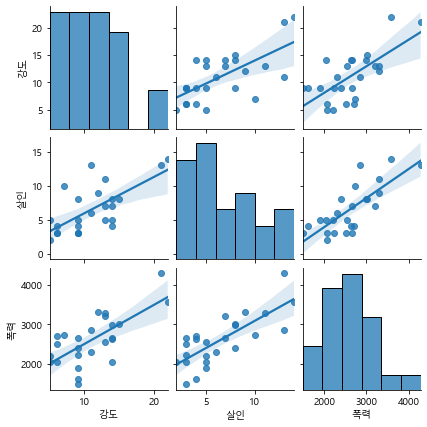

In [189]:
sns.pairplot(crime_anal, vars=["강도", "살인", "폭력"], size=2, kind="reg")

#### 3-2. 인구수와 CCTV갯수, 그리고 강도와 살인에 대한 상관 관계

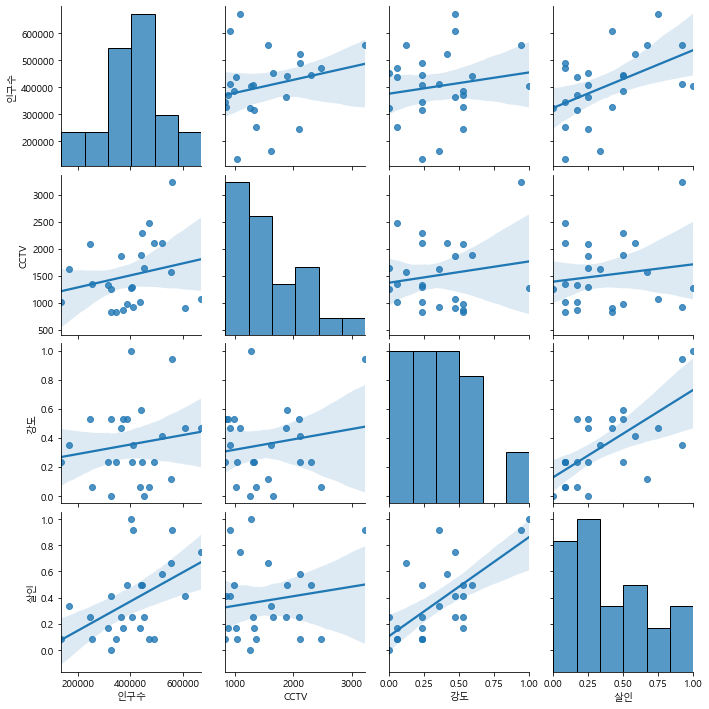

In [190]:
sns.pairplot(crime_anal_norm, vars=["인구수", "CCTV", "강도", "살인"], kind="reg")

#### 3-3. 살인 및 폭력 검거율과 인구수 및 CCTV의 상관 관계

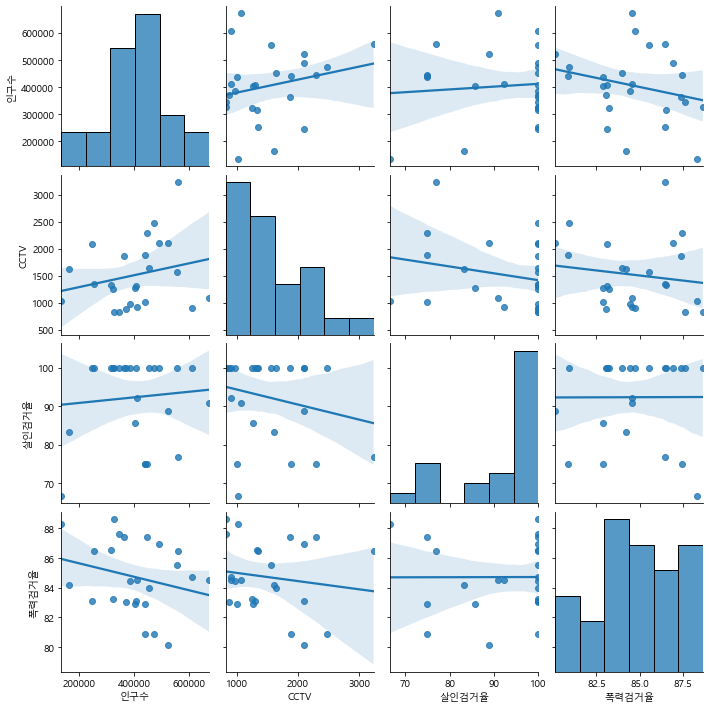

In [191]:
sns.pairplot(crime_anal_norm, vars=["인구수", "CCTV", "살인검거율", "폭력검거율"], kind="reg")

#### 3-4. 절도 및 강도 검거율과 인구수 및 CCTV의 상관 관계

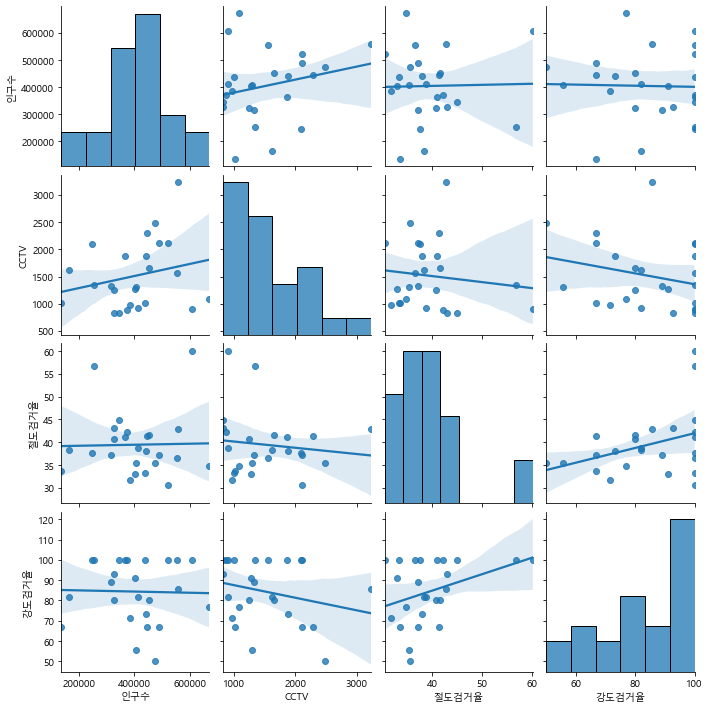

In [192]:
sns.pairplot(crime_anal_norm, vars=["인구수", "CCTV", "절도검거율", "강도검거율"], kind="reg")

#### 3-5. 지역별 검거율

In [193]:
##### 정규화
tmp_max = crime_anal_norm["검거"].max()
crime_anal_norm["검거"] = crime_anal_norm["검거"]/tmp_max * 100

crime_anal_norm_sort = crime_anal_norm.sort_values(by="검거", ascending=False)
crime_anal_norm_sort

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
도봉구,0.000000,0.235294,0.083333,0.000000,0.000000,100.000000,100.000000,100.000000,44.967074,87.626093,345041,825,0.318627,100.000000
금천구,0.141210,0.058824,0.083333,0.180840,0.202717,80.794702,100.000000,100.000000,56.668794,86.465433,253344,1348,0.666924,97.997139
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,608361,911,2.333944,96.572809
광진구,0.397695,0.529412,0.166667,0.704342,0.406864,91.666667,100.000000,100.000000,42.200925,83.047619,371671,878,2.204979,96.375820
동대문구,0.204611,0.470588,0.250000,0.329386,0.379335,84.393064,100.000000,100.000000,41.090358,87.401884,364962,1870,1.633921,95.444250
용산구,0.265130,0.529412,0.250000,0.177252,0.201287,89.175258,100.000000,100.000000,37.700706,83.121951,245411,2096,1.423080,94.776790
성동구,0.069164,0.235294,0.166667,0.195192,0.044691,94.444444,88.888889,100.000000,37.149969,86.538462,314551,1327,0.711008,94.088810
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,327511,831,1.641616,94.070728
성북구,0.138329,0.000000,0.250000,0.259060,0.258134,82.666667,80.000000,100.000000,41.512605,83.974649,453902,1651,0.905522,89.727243


Text(0.5, 1.0, '범죄 검거 비율(정규화된 검거의 합으로 정렬)')

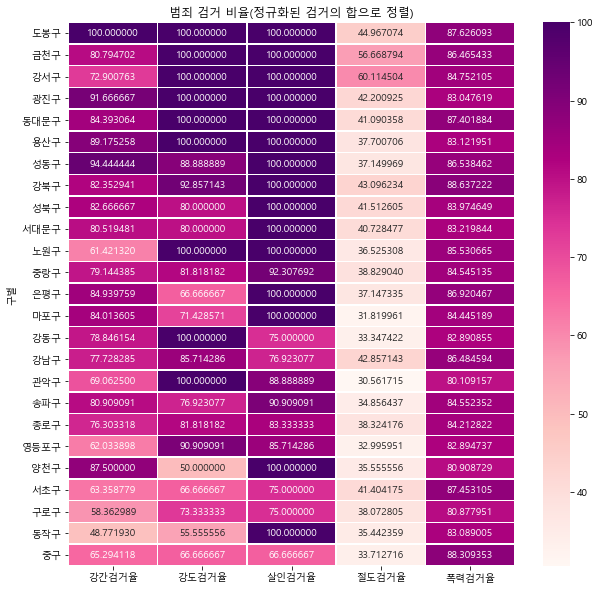

In [194]:
##### 히트맵 : 정렬된 결과를 한번에 쉽게 확인할 수 있게 해주는 그래프

plt.figure(figsize=(10, 10))
sns.heatmap(crime_anal_norm_sort[["강간검거율", "강도검거율", "살인검거율",
                                 "절도검거율", "폭력검거율"]], cmap="RdPu",
           annot=True, fmt="f", linewidths=.5)

plt.title("범죄 검거 비율(정규화된 검거의 합으로 정렬)")

#### 3-6. 지역별 발생 건수

In [195]:
cols = ["강간", "강도", "살인", "절도", "폭력"]
crime_anal_norm["범죄"] = crime_anal_norm["범죄"] / 5
crime_anal_norm_sort = crime_anal_norm.sort_values(by="범죄", ascending=False)
crime_anal_norm_sort

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,557865,3238,0.971569,85.463066
영등포구,0.556196,1.000000,1.000000,0.682095,0.745442,62.033898,90.909091,85.714286,32.995951,82.894737,403988,1277,0.796747,81.958753
송파구,0.340058,0.470588,0.750000,0.780768,0.646407,80.909091,76.923077,90.909091,34.856437,84.552352,671994,1081,0.597564,85.103066
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,522292,2109,0.572068,85.212224
마포구,0.553314,0.529412,0.500000,0.535343,0.534859,84.013605,71.428571,100.000000,31.819961,84.445189,385624,980,0.530585,85.925381
구로구,0.515850,0.588235,0.500000,0.456405,0.543439,58.362989,73.333333,75.000000,38.072805,80.877951,440396,1884,0.520786,75.277906
서초구,0.838617,0.235294,0.500000,0.564047,0.326064,63.358779,66.666667,75.000000,41.404175,87.453105,445164,2297,0.492804,77.181692
중랑구,0.244957,0.352941,0.916667,0.384643,0.486235,79.144385,81.818182,92.307692,38.829040,84.545135,411552,916,0.477089,87.066663
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,608361,911,0.466789,96.572809


Text(0.5, 1.0, '범죄 발생 비율(정규화된 발생 건수의 합으로 정렬)')

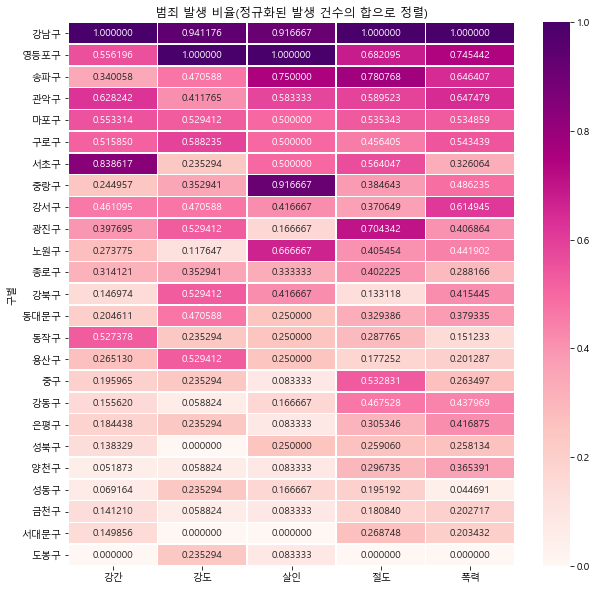

In [196]:
plt.figure(figsize=(10, 10))
sns.heatmap(crime_anal_norm_sort[cols], cmap="RdPu",
           annot=True, fmt="f", linewidths=.5)

plt.title("범죄 발생 비율(정규화된 발생 건수의 합으로 정렬)")

#### 3-7. Checkpoint

In [197]:
crime_anal_norm.to_csv("data/seoul/crime_in_seoul_final.csv", encoding="utf-8")

In [198]:
crime_anal_norm = pd.read_csv("data/seoul/crime_in_seoul_final.csv", index_col="구별")
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,557865,3238,0.971569,85.463066
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,438225,1010,0.257321,85.550226
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,327511,831,0.328323,94.070728
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,608361,911,0.466789,96.572809
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,522292,2109,0.572068,85.212224


### 4. 지도 시각화

+ https://github.com/southkorea/southkorea-maps


In [199]:
import folium
import json

In [200]:
geo_path = "data/seoul/skorea_municipalities_geo_simple_seoul.json"

geo_str = json.load(open(geo_path, encoding="utf-8"))

map = folium.Map(location=[37.497911, 127.027558], zoom_start=10, tiles="Stamen Toner")
map

# key_on = "feature.id" or "feature.properties.속성명"
map.choropleth(geo_data=geo_str, data=crime_anal_norm["살인"], 
              columns=[crime_anal_norm.index, crime_anal_norm["살인"]], 
              key_on="feature.id", fill_color="PuRd")

map

In [201]:
map = folium.Map(location=[37.497911, 127.027558], zoom_start=10)

map.choropleth(geo_data=geo_str, data=crime_anal_norm["범죄"], 
              columns=[crime_anal_norm.index, crime_anal_norm["범죄"]], 
              key_on="feature.id", fill_color="PuRd")

map

#### 4-1. 인구 대비 범죄 발생 비율

In [202]:
murder_criminal = crime_anal_norm["살인"] / crime_anal_norm["인구수"]  * 1000000
murder_criminal.head()

구별
강남구    1.643169
강동구    0.380322
강북구    1.272222
강서구    0.684900
관악구    1.116872
dtype: float64

In [203]:
map = folium.Map(location=[37.497911, 127.027558], zoom_start=10)

map.choropleth(geo_data=geo_str, data=murder_criminal, 
              columns=[crime_anal_norm.index, murder_criminal], 
              key_on="feature.id", fill_color="PuRd")

map

#### 4-2. 경찰서별 검거율과 구별 범죄 발생률을 동시에 시각화

In [204]:
crime_anal_police = pd.read_csv("data/seoul/crime_in_seoul_include_gu_name.csv", index_col=0)
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563647,126.989580,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575558,126.984867,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564744,126.966771,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571853,126.998914,1.198382


In [205]:
station_lat = [37.5636465, 37.5755578, 37.5547584, 37.5647439, 37.5718529, 37.5387099, 37.5897482, 37.58506149999999, 37.550814, 37.5153176, 37.5617303, 37.5130866, 37.542873, 37.6020914, 37.63730390000001, 37.4568722, 37.6186095, 37.5094352, 37.4743789, 37.5397827, 37.528511, 37.6020592, 37.494931, 37.4956054, 37.5165667, 37.5016941, 37.6425238, 37.4945959, 37.6283597, 37.6533589, 37.49349]
station_lng = [126.9895796, 126.9848674, 126.9734981, 126.9667705, 126.9989143, 126.9659183, 127.0161353, 127.0457679, 126.954028, 126.905728, 127.0364217, 126.9428498, 127.083821, 126.9213528, 127.0273399, 126.8970429, 127.1045734, 127.0669578, 126.9509748, 126.8299968, 127.1268224, 127.0321577, 126.886731, 127.0052504, 126.8656763, 127.1272481, 127.0717076, 126.9831279, 126.9287226, 127.052682, 127.0772119]

In [206]:
crime_anal_police["lat"] = station_lat
crime_anal_police["lng"] = station_lng
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563646,126.989580,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575558,126.984867,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564744,126.966770,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571853,126.998914,1.198382


In [207]:
##### 검거율 정규화

cols = ["살인 검거", "강도 검거", "강간 검거", "절도 검거", "폭력 검거"]
tmp = crime_anal_police[cols] / crime_anal_police.max()

crime_anal_police["검거"] = np.sum(tmp, axis=1)
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563646,126.989580,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575558,126.984867,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564744,126.966770,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571853,126.998914,1.198382


In [208]:
##### 경찰서 위치를 지도에 마킹하기
map = folium.Map(location=[37.497911, 127.027558], zoom_start=11)

for n in crime_anal_police.index:
    folium.Marker(location=[crime_anal_police["lat"][n], crime_anal_police["lng"][n]], 
                       icon=folium.Icon(color="red", icon="star"),
                      popup=crime_anal_police["관서명"][n]).add_to(map)

map

In [209]:
##### 각 경찰서별로 검거율을 CircleMarker로 출력

map = folium.Map(location=[37.497911, 127.027558], zoom_start=11)

for n in crime_anal_police.index:
    folium.CircleMarker(location=[crime_anal_police["lat"][n], crime_anal_police["lng"][n]], 
                       popup=crime_anal_police["관서명"][n],
                       radius=crime_anal_police["검거"][n] * 10, 
                        color="#ffffgg", fill_color="#fffggg").add_to(map)

map

In [210]:
map = folium.Map(location=[37.497911, 127.027558], zoom_start=11)

map.choropleth(geo_data=geo_str, data=murder_criminal, 
              columns=[crime_anal_norm.index, murder_criminal], 
              key_on="feature.id", fill_color="PuRd")

for n in crime_anal_police.index:
    folium.CircleMarker(location=[crime_anal_police["lat"][n], crime_anal_police["lng"][n]], 
                       popup=crime_anal_police["관서명"][n],
                       radius=crime_anal_police["검거"][n] * 10, 
                        color="#3186cc", fill_color="#3186cc").add_to(map)

map